# Advanced usage

### python test class


### config files

Provide option to input config files, in the form I want to get, if they don't provide any, you give/use default values. 
.txt format

Describe it in the documentation how it should look like.

In [3]:
from openTSNE import TSNEEmbedding
from openTSNE import initialization
from openTSNE.callbacks import ErrorLogger


import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## Load data

In [4]:
from sklearn import datasets

iris = datasets.load_iris()
x, y = iris["data"], iris["target"]

In [5]:
print("Data set contains %d samples with %d features" % x.shape)

Data set contains 150 samples with 4 features


## Create train/test split

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.33, random_state=42)

In [7]:
print("%d training samples" % x_train.shape[0])
print("%d test samples" % x_test.shape[0])

100 training samples
50 test samples


## Create a t-SNE embedding

Like in the *simple_usage* notebook, we will run the standard t-SNE optimization.

This example shows the standard t-SNE optimization. Much can be done in order to better preserve global structure and improve embedding quality. Please refer to the *preserving_global_structure* notebook for some examples.

**1. Compute the affinities between data points**

In [8]:
class KNNIndex_Elements:
    def __init__(self, metric, metric_params=None, n_jobs=1, random_state=None):
        self.index = None
        self.metric = metric
        self.metric_params = metric_params
        self.n_jobs = n_jobs
        self.random_state = random_state

    def build(self, data):
        """Build the index so we can query nearest neighbors."""

    def query_train(self, data, k):
        """Query the index for the points used to build index."""

    def query(self, query, k):
        """Query the index with new points."""

    def check_metric(self, metric):
        """Check that the metric is supported by the KNNIndex instance."""

class Annoy:
    """
    """
    
#####       
#self.knn_index = build_knn_index(
#            data, method, metric, metric_params, n_jobs, random_state
#        )

### import affinity_multiann.py

In [9]:
import logging
import operator
from functools import reduce

import numpy as np
import scipy.sparse as sp

#from . import nearest_neighbors

log = logging.getLogger(__name__)

from openTSNE.affinity import PerplexityBasedNN, MultiscaleMixture, FixedSigmaNN, joint_probabilities_nn
from openTSNE import nearest_neighbors

class MultiANNPerplexityBasedNN(PerplexityBasedNN):
    """Compute affinities using nearest neighbors.
    """

    #super init !    
    def __init__(
        self,
        data,
        perplexity=30,
        method="approx",
        metric="euclidean",
        metric_params=None,
        symmetrize=True,
        n_jobs=1,
        random_state=None,
    ):
        self.n_samples = data.shape[0]
        self.perplexity = self.check_perplexity(perplexity)

        self.knn_index = build_knn_index(
            data, method, metric, metric_params, n_jobs, random_state
        )

        # Find and store the nearest neighbors so we can reuse them if the
        # perplexity is ever lowered
        k_neighbors = min(self.n_samples - 1, int(3 * self.perplexity))
        self.__neighbors, self.__distances = self.knn_index.query_train(
            data, k=k_neighbors
        )
        #print("Neighbors:")
        #print(self.__neighbors)
        #print(len(self.__neighbors))
        #print("Distances:")
        #print(self.__distances)
        #print(len(self.__distances[0]))

        self.P = joint_probabilities_nn(
            self.__neighbors,
            self.__distances,
            [self.perplexity],
            symmetrize=symmetrize,
            n_jobs=n_jobs,
        )

        self.n_jobs = n_jobs
        
        
        
def build_knn_index(
    data, method, metric, metric_params=None, n_jobs=1, random_state=None
):
    methods = {
        #"exact_alt": nearest_neighbors.VPTree,
        "exact": nearest_neighbors.BallTree,
        "approx": nearest_neighbors.NNDescent,
        #cs: options for ann algorithms
        "balltree": nearest_neighbors.BallTree,
        "nndescent": nearest_neighbors.NNDescent,
        #"annoy": multi_nearest_neighbors.Annoy, (if filelocation in sumfile)
        #"annoy": algorithms.annoy.Annoy (if filelocation in folder)
        "annoy": Annoy,
        #"hnswlib": Hnswlib,
        #"rpforest": RPForest,
        #"flann": FLANN,
        #"onng": ONNG,
        "nearpy": NearPy,
    }
    if isinstance(method, nearest_neighbors.KNNIndex):
        knn_index = method

    elif method not in methods:
        raise ValueError(
            "Unrecognized nearest neighbor algorithm `%s`. "
            "Please choose one of the supported methods or "
            "provide a valid `KNNIndex` instance." % method
        )
    else:
        knn_index = methods[method](
            metric=metric,
            metric_params=metric_params,
            n_jobs=n_jobs,
            random_state=random_state,
        )

    knn_index.build(data)

    return knn_index        

In [10]:
# class MultiANNFixedSigmaNN(FixedSigmaNN):
#     """Compute affinities using using nearest neighbors and a fixed bandwidth
#     for the Gaussians in the ambient space.
# 
#     Using a fixed Gaussian bandwidth can enable us to find smaller clusters of
#     data points than we might be able to using the automatically determined
#     bandwidths using perplexity. Note however that this requires mostly trial
#     and error.
#     """
# 
#     def __init__(
#         self,
#         data,
#         sigma,
#         k=30,
#         method="exact",
#         metric="euclidean",
#         metric_params=None,
#         symmetrize=True,
#         n_jobs=1,
#         random_state=None,
#     ):
#         self.n_samples = n_samples = data.shape[0]
# 
#         if k >= self.n_samples:
#             raise ValueError(
#                 "`k` (%d) cannot be larger than N-1 (%d)." % (k, self.n_samples)
#             )
# 
#         knn_index, neighbors, distances = build_knn_index(
#             data, method, k, metric, metric_params, n_jobs, random_state
#         )
# 
#         self.knn_index = knn_index
# 
#         # Compute asymmetric pairwise input similarities
#         conditional_P = np.exp(-distances ** 2 / (2 * sigma ** 2))
#         conditional_P /= np.sum(conditional_P, axis=1)[:, np.newaxis]
# 
#         P = sp.csr_matrix(
#             (conditional_P.ravel(), neighbors.ravel(), range(0, n_samples * k + 1, k)),
#             shape=(n_samples, n_samples),
#         )
# 
#         # Symmetrize the probability matrix
#         if symmetrize:
#             P = (P + P.T) / 2
# 
#         # Convert weights to probabilities
#         P /= np.sum(P)
# 
#         self.sigma = sigma
#         self.k = k
#         self.P = P
#         self.n_jobs = n_jobs
#
#
# class MultiANNMultiscaleMixture(MultiscaleMixture):
#     """Calculate affinities using a Gaussian mixture kernel.
# 
#     Instead of using a single perplexity to compute the affinities between data
#     points, we can use a multiscale Gaussian kernel instead. This allows us to
#     incorporate long range interactions.
#     """
# 
#     def __init__(
#         self,
#         data,
#         perplexities,
#         method="exact",
#         metric="euclidean",
#         metric_params=None,
#         symmetrize=True,
#         n_jobs=1,
#         random_state=None,
#     ):
#         self.n_samples = data.shape[0]
# 
#         # We will compute the nearest neighbors to the max value of perplexity,
#         # smaller values can just use indexing to truncate unneeded neighbors
#         perplexities = self.check_perplexities(perplexities)
#         max_perplexity = np.max(perplexities)
#         k_neighbors = min(self.n_samples - 1, int(3 * max_perplexity))
# 
#         self.knn_index, self.__neighbors, self.__distances = build_knn_index(
#             data, method, k_neighbors, metric, metric_params, n_jobs, random_state
#         )
# 
#         self.P = self._calculate_P(
#             self.__neighbors,
#             self.__distances,
#             perplexities,
#             symmetrize=symmetrize,
#             n_jobs=n_jobs,
#         )
# 
#         self.perplexities = perplexities
#         self.n_jobs = n_jobs
# 
# class MultiANNMultiscale(MultiANNMultiscaleMixture):
#     """Calculate affinities using averaged Gaussian perplexities.
# 
#     In contrast to :class:`MultiscaleMixture`, which uses a Gaussian mixture
#     kernel, here, we first compute single scale Gaussian kernels, convert them
#     to probability distributions, then average them out between scales.
# 
#     Please see the :ref:`parameter-guide` for more information.
#     """
# 
#     @staticmethod
#     def _calculate_P(
#         neighbors,
#         distances,
#         perplexities,
#         symmetrize=True,
#         normalization="pair-wise",
#         n_reference_samples=None,
#         n_jobs=1,
#     ):
#         # Compute normalized probabilities for each perplexity
#         partial_Ps = [
#             joint_probabilities_nn(
#                 neighbors,
#                 distances,
#                 [perplexity],
#                 symmetrize=symmetrize,
#                 normalization=normalization,
#                 n_reference_samples=n_reference_samples,
#                 n_jobs=n_jobs,
#             )
#             for perplexity in perplexities
#         ]
#         # Sum them together, then normalize
#         P = reduce(operator.add, partial_Ps, 0)
# 
#         # Take care to properly normalize the affinity matrix
#         if normalization == "pair-wise":
#             P /= np.sum(P)
#         elif normalization == "point-wise":
#             P = sp.diags(np.asarray(1 / P.sum(axis=1)).ravel()) @ P
# 
#         return P

### import multi_nearest_neighbors.py

### annparameters.py

In [11]:
def init_method_param(method, data=None):
    """
    Get method parameters based on approximate nearest neighbor algorithm and data (shape, vector)
    
    Input: name of method as string, data as np.array ([num_items][vector_length])
    Output: method_param as directory. Keys corresponding to the method-specific parameters
    """
    config_file = ""
    config_file = None

    if method == "nearpy":
        if not config_file:
            mp = {}
            
            # number of bits, as int
            mp['n_bits'] = 4 # ????? How many as standard? 
            
            # hash counts, as int
            mp['hash_counts'] = 5 # ????? How many as standard? 
    
    elif method == "annoy":

        if not config_file:
            n_items, vector_length = data.shape
            mp = {}
            
            # number of trees, as int
            mp["ntrees"] = 5 + int(round((n_items) ** 0.5 / 20))
    
    else:
        print("Error: ANN for init_method_param not found")
        return 
        
    return mp

In [12]:
print(init_method_param("nearpy"))

{'n_bits': 4, 'hash_counts': 5}


### NearPy

In [69]:
from openTSNE.nearest_neighbors import KNNIndex
import nearpy
from nearpy.filters import NearestFilter
import sklearn.preprocessing

class NearPy(KNNIndex):
    #VALID_METRICS = neighbors.NearPy.valid_metrics
    #METHOD_PARAMS = neighbors.NearPy.params (text/config file)
    
    def build(self, data): 
        n_items, vector_length = data.shape
        print(data.shape)
        #parameters init
        method_param = init_method_param("nearpy")
        self.filter = NearestFilter(10)
        
        hashes = []
        for k in range(method_param["hash_counts"]):
            nearpy_rbp = nearpy.hashes.RandomBinaryProjections(
                'rbp_%d' % k, method_param["n_bits"])
            hashes.append(nearpy_rbp)

        if self.metric == 'euclidean':
            dist = nearpy.distances.EuclideanDistance()
            self.index = nearpy.Engine(
                vector_length,
                lshashes=hashes,
                distance=dist,
                vector_filters=[self.filter])
        else:  # Default (angular) = Cosine distance
            self.index = nearpy.Engine(
                vector_length,
                lshashes=hashes,
                vector_filters=[self.filter])
            
        #if self.metric == 'angular':
            #data = sklearn.preprocessing.normalize(data, axis=1, norm='l2')
        for i, x in enumerate(data):
            self.index.store_vector(x, i)
            
    def query_train(self, data, k):
        self.filter.N = k
        print(k)
        #if self.metric == 'angular':
            #data = sklearn.preprocessing.normalize([data], axis=1, norm='l2')[0]
        
        neighbors = np.empty((data.shape[0],k), dtype=int)
        distances = np.empty((data.shape[0],k))
        for i in range(len(data)):
            #vector = data[i]
            neighbors_single = self.index.neighbours(data[i])
            #print(len(neighbors_single))
            #print(np.asarray(neighbors_single))
            dp_n = []
            dp_d = []
            for j in range(len(neighbors_single)):
                dp_n.append(neighbors_single[j][1])
                dp_d.append(neighbors_single[j][2])
            neighbors[i] = np.asarray(dp_n)
            distances[i] = np.asarray(dp_d)
            
        print("dp_n: {}".format(dp_n))
        print("neighbors.shape: {}".format(neighbors.shape))
        #print("neighbors[0]: {}".format(neighbors[0]))
        
        print("dp_d: {}".format(dp_d))
        print("distances.shape: {}".format(distances.shape))
        #print("distances[0]: {}".format(distances[0]))
        return neighbors, distances
        #print(neighbors[0],distances[0])
        #return neighbors, distances
    

    def query(self, query, k):
        self.filter.N = k
        if self.metric == 'angular':
            query = sklearn.preprocessing.normalize([query], axis=1, norm='l2')[0]
        return [y for x, y, z in self.index.neighbours(query)]

In [70]:
affinities_train = MultiANNPerplexityBasedNN(
    x,
    perplexity=30,
    method="nearpy",
    metric="euclidean",
    n_jobs=8,
    random_state=42,
)

#possible solution
#affinities_train.knn_index = stelmach.build_knn_index()

print("P:")
print(affinities_train.P)
print("")

#print("data:")
#print(affinities_train.data)
#print("")

print("knn_index:")
print(affinities_train.knn_index)

#print(".index")
#print(affinities_train.index)


(150, 4)
90
dp_n: [149, 124, 117, 137, 109, 127, 116, 143, 101, 142, 138, 121, 106, 103, 120, 70, 147, 131, 84, 83, 104, 110, 115, 148, 66, 112, 144, 136, 140, 128, 125, 139, 102, 126, 111, 132, 113, 133, 55, 123, 90, 100, 145, 63, 78, 59, 77, 114, 91, 94, 146, 56, 105, 129, 135, 141, 107, 134, 89, 72, 96, 73, 85, 130, 61, 108, 99, 53, 88, 119, 95, 51, 54, 52, 122, 86, 97, 76, 92, 69, 58, 80, 118, 68, 67, 60, 82, 75, 74, 57]
neighbors.shape: (150, 90)
dp_d: [0.0, 0.013326045075696085, 0.01693272501435845, 0.020972957890048834, 0.03189362734680065, 0.032932540211072434, 0.03327924474671744, 0.03477885641723165, 0.03502305079662377, 0.03502305079662377, 0.035123030106931595, 0.03542922450058204, 0.036329849298748135, 0.039520227395661904, 0.03993388714500637, 0.04070918369663919, 0.04181292975683996, 0.04290657997998921, 0.043128106462641105, 0.043169406454368925, 0.04364471236253631, 0.044437354533735325, 0.044904359314600524, 0.04755526778337658, 0.04809155233234756, 0.0481067834174292

In [60]:
# -*- coding: utf-8 -*-

# Copyright (c) 2013 Ole Krause-Sparmann

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

import numpy
import scipy
import unittest
import time

from nearpy import Engine
from nearpy.distances import CosineDistance, EuclideanDistance

from nearpy.hashes import RandomBinaryProjections, HashPermutations, HashPermutationMapper


from nearpy.filters import NearestFilter

def example2(data):
    print("data.shape: {}".format(data.shape))
    # Dimension of feature space
    DIM = data.shape[1]

    # Number of data points (dont do too much because of exact search)
    POINTS = data.shape[0]

    _filter = NearestFilter(20)
    #######

    print('\nPerforming indexing with multiple binary hashes...')
    t0 = time.time()

    hashes = []
    for k in range(30):
        hashes.append(RandomBinaryProjections('rbp_%d' % k, 10))

    # Create engine
    engine_rbps = Engine(DIM, lshashes=hashes, distance=EuclideanDistance())

    # First index some random vectors
    #matrix = numpy.zeros((POINTS,DIM))
    matrix = numpy.asarray(data)
    #print(matrix)
    #for i in range(POINTS):
        #v = numpy.random.randn(DIM)
        #matrix[i] = v
    #    engine_rbps.store_vector(matrix[i])
    for i, x in enumerate(data):
        engine_rbps.store_vector(x, i)

    t1 = time.time()
    print('Indexing took %f seconds' % (t1-t0))

    # Get random query vector
    query = matrix[0]
    # Do random query on engine 4
    print('\nNeighbour distances with multiple binary hashes:')
    print("query: {}".format(query))
    print('  -> Candidate count is %d' % engine_rbps.candidate_count(query))
    results = engine_rbps.neighbours(query,vector_filter=[_filter])
    print('Results: {}'.format(results))
    neigh = [x[1] for x in results]
    dists = [x[2] for x in results]
    print(neigh, dists)

    # Real neighbours
    #print('\nReal neighbour distances:')
    #print("1. Query: {}".format(query))
    #query = query.reshape((DIM))
    #print("2. Query: {}".format(query))
    #print("0. dists: {}".format(dists))
    #dists = EuclideanDistance().distance(matrix,query)
    #print("2. cosineDistance dists: {}".format(dists))
    #dists = dists.reshape((-1,))
    #print("3. reshape dists: {}".format(dists))
    #dists = sorted(dists)
    #print("4. sorted dists: {}".format(dists))
    #print(len(dists))
    #print(len(dists[0]))
    #print(dists[:30])

    
    #print(engine_rbps._get_candidates(matrix[0]))
    ##########################################################
    
example2(x)

data.shape: (150, 4)

Performing indexing with multiple binary hashes...
Indexing took 0.157069 seconds

Neighbour distances with multiple binary hashes:
query: [5.1 3.5 1.4 0.2]
  -> Candidate count is 2265


TypeError: neighbours() got an unexpected keyword argument 'vector_filter'

In [293]:
# -*- coding: utf-8 -*-

# Copyright (c) 2013 Ole Krause-Sparmann

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.
from __future__ import print_function

import numpy
import scipy
import time

from scipy.spatial.distance import cdist

from nearpy.utils import numpy_array_from_list_or_numpy_array
from nearpy.utils.utils import unitvec


class RecallPrecisionExperiment(object):
    """
    Performs nearest neighbour recall experiments with custom vector data
    for all engines in the specified list.
    perform_experiment() returns list of (recall, precision, search_time)
    tuple. These are the averaged values over all request vectors. search_time
    is the average retrieval/search time compared to the average exact search
    time.
    coverage_ratio determines how many of the vectors are used as query
    vectors for exact andapproximated search. Because the search comparance
    overhead is quite large, it is best with large data sets (>10000) to
    use a low coverage_ratio (like 0.1) to make the experiment fast. A
    coverage_ratio of 0.1 makes the experiment use 10% of all the vectors
    for querying, that is, it looks for 10% of all vectors for the nearest
    neighbours.
    """

    def __init__(self, N, vectors, coverage_ratio=0.2):
        """
        Performs exact nearest neighbour search on the data set.
        vectors can either be a numpy matrix with all the vectors
        as columns OR a python array containing the individual
        numpy vectors.
        """
        # We need a dict from vector string representation to index
        self.vector_dict = {}
        self.N = N
        print("N: {}".format(N))
        self.coverage_ratio = coverage_ratio
        self.vectors = numpy_array_from_list_or_numpy_array(vectors)

        # Get numpy array representation of input
        #self.vectors = numpy.vstack([unitvec(v) for v in numpy_vectors.T])
        #print(self.vectors)
        print(len(self.vectors))
        ## Build map from vector string representation to vector
        for index, v in enumerate(self.vectors):
            self.vector_dict[self.__vector_to_string(v)] = index
        
        # Determine the indices of query vectors used for comparance
        # with approximated search.
        query_count = numpy.floor(self.coverage_ratio *
                                  len(self.vectors))
        print(query_count)
        self.query_indices = []
        for k in range(int(query_count)):
            index = numpy.floor(k * (float(len(self.vectors)) / query_count))
            index = min(index, len(self.vectors) - 1)
            self.query_indices.append(int(index))

        print('\nStarting exact search (query set size=%d)...\n' % query_count)

        # For each query vector get the closest N neighbours
        self.closest = {}
        self.exact_search_time_per_vector = 0.0

        for index in self.query_indices:
            v = self.vectors[index, numpy.newaxis]
            exact_search_start_time = time.time()
            D = cdist(v, self.vectors, 'euclidean')
            self.closest[index] = scipy.argsort(D)[0, 1:N+1]

            # Save time needed for exact search
            exact_search_time = time.time() - exact_search_start_time
            self.exact_search_time_per_vector += exact_search_time

        print('Done with exact search...\n')

        # Normalize search time
        self.exact_search_time_per_vector /= float(len(self.query_indices))

    def perform_experiment(self, engine_list):
        """
        Performs nearest neighbour recall experiments with custom vector data
        for all engines in the specified list.
        Returns self.result contains list of (recall, precision, search_time)
        tuple. All are the averaged values over all request vectors.
        search_time is the average retrieval/search time compared to the
        average exact search time.
        """
        # We will fill this array with measures for all the engines.
        result = []

        # For each engine, first index vectors and then retrieve neighbours
        for endine_idx, engine in enumerate(engine_list):
            print('Engine %d / %d' % (endine_idx, len(engine_list)))

            # Clean storage
            engine.clean_all_buckets()
            # Use this to compute average recall
            avg_recall = 0.0
            # Use this to compute average precision
            avg_precision = 0.0
            # Use this to compute average search time
            avg_search_time = 0.0

            # Index all vectors and store them
            for index, v in enumerate(self.vectors):
                engine.store_vector(v, 'data_%d' % index)

            # Look for N nearest neighbours for query vectors
            for index in self.query_indices:
                # Get indices of the real nearest as set
                real_nearest = set(self.closest[index])
                print("Get indices of the real nearest as set: {}".format(len(real_nearest)))
                # We have to time the search
                search_time_start = time.time()

                # Get nearest N according to engine
                nearest = engine.neighbours(self.vectors[index])
                print("Get nearest N according to engine: {}".format(len(nearest)))
                # Get search time
                search_time = time.time() - search_time_start

                # For comparance we need their indices (as set)
                nearest = set([self.__index_of_vector(x[0]) for x in nearest])

                # Remove query index from search result to make sure that
                # recall and precision make sense in terms of "neighbours".
                # If ONLY the query vector is retrieved, we want recall to be
                # zero!
                nearest.remove(index)

                # If the result list is empty, recall and precision are 0.0
                if len(nearest) == 0:
                    recall = 0.0
                    precision = 0.0
                else:
                    # Get intersection count
                    inter_count = float(len(real_nearest & nearest))

                    # Normalize recall for this vector
                    recall = inter_count/float(len(real_nearest))

                    # Normalize precision for this vector
                    precision = inter_count/float(len(nearest))

                # Add to accumulator
                avg_recall += recall

                # Add to accumulator
                avg_precision += precision

                # Add to accumulator
                avg_search_time += search_time

            # Normalize recall over query set
            avg_recall /= float(len(self.query_indices))

            # Normalize precision over query set
            avg_precision /= float(len(self.query_indices))

            # Normalize search time over query set
            avg_search_time = avg_search_time / float(len(self.query_indices))

            # Normalize search time with respect to exact search
            avg_search_time /= self.exact_search_time_per_vector

            print('  recall=%f, precision=%f, time=%f' % (avg_recall,
                                                          avg_precision,
                                                          avg_search_time))

            result.append((avg_recall, avg_precision, avg_search_time))

        # Return (recall, precision, search_time) tuple
        return result

    def __vector_to_string(self, vector):
        """ Returns string representation of vector. """
        return numpy.array_str(numpy.round(unitvec(vector), decimals=3))

    def __index_of_vector(self, vector):
        """ Returns index of specified vector from test data set. """
        return self.vector_dict[self.__vector_to_string(vector)]
    


In [294]:
def build_engine(data): 
        n_items, vector_length = data.shape
        #print(data)
        #parameters init
        method_param = init_method_param("nearpy")
        filter = NearestFilter(10)
        
        hashes = []
        for k in range(method_param["hash_counts"]):
            nearpy_rbp = nearpy.hashes.RandomBinaryProjections(
                'rbp_%d' % k, method_param["n_bits"])
            hashes.append(nearpy_rbp)
        metric = "euclidean"
        if metric == 'euclidean':
            dist = nearpy.distances.EuclideanDistance()
            index = nearpy.Engine(
                vector_length,
                lshashes=hashes,
                distance=dist)
        else:  # Default (angular) = Cosine distance
            index = nearpy.Engine(
                vector_length,
                lshashes=hashes,
                vector_filters=[self.filter])
            
        return index

In [295]:
#print(x)
#print(x.shape)
init = RecallPrecisionExperiment(90, x, 0.9)

engine = build_engine(x)
init.perform_experiment([engine])
#
#        __init__(self, N, vectors, coverage_ratio=0.2)

N: 90
150
30.0

Starting exact search (query set size=30)...

Done with exact search...

Engine 0 / 1
Get indices of the real nearest as set: 90
Get nearest N according to engine: 10
Get indices of the real nearest as set: 90
Get nearest N according to engine: 10
Get indices of the real nearest as set: 90
Get nearest N according to engine: 10
Get indices of the real nearest as set: 90
Get nearest N according to engine: 10
Get indices of the real nearest as set: 90
Get nearest N according to engine: 10
Get indices of the real nearest as set: 90
Get nearest N according to engine: 10
Get indices of the real nearest as set: 90
Get nearest N according to engine: 10
Get indices of the real nearest as set: 90
Get nearest N according to engine: 10
Get indices of the real nearest as set: 90
Get nearest N according to engine: 10
Get indices of the real nearest as set: 90
Get nearest N according to engine: 10
Get indices of the real nearest as set: 90
Get nearest N according to engine: 10
Get ind

[(0.0977777777777778, 0.9777777777777779, 32.542120408508715)]

In [37]:
import numpy

from nearpy import Engine
from nearpy.hashes import RandomBinaryProjections

# Dimension of our vector space
dimension = 2

# Create a random binary hash with 10 bits
rbp = RandomBinaryProjections('rbp', 10)

# Create engine with pipeline configuration
engine = Engine(dimension, lshashes=[rbp])

# Index 1000000 random vectors (set their data to a unique string)
for index in range(150):
    v = numpy.random.randn(dimension)
    engine.store_vector(v, 'data_%d' % index)

# Create random query vector
query = numpy.random.randn(dimension)

# Get nearest neighbours
N = engine.neighbours(query)
print(query)
print(N)

[-1.68367934  0.4976707 ]
[(array([-0.95665394,  0.29122712]), 'data_38', 3.286715308148391e-05), (array([-0.96197981,  0.27312056]), 'data_118', 5.7954759213441065e-05), (array([-0.95090124,  0.30949447]), 'data_50', 0.0003715234882036844), (array([-0.96908529,  0.24672597]), 'data_28', 0.000725766565274788), (array([-0.9381949,  0.3461074]), 'data_137', 0.0021783483999329167), (array([-0.93341192,  0.35880663]), 'data_24', 0.003165410069035701), (array([-0.9312681 ,  0.36433464]), 'data_45', 0.0036543181386105017), (array([-0.98014272,  0.19829333]), 'data_14', 0.0038506514393582547), (array([-0.98996828,  0.14128976]), 'data_74', 0.010586408235638833), (array([-0.90752389,  0.42000045]), 'data_69', 0.010645512652042166)]


### ONNG:

In [ ]:
#from __future__ import absolute_import
import ngtpy
import numpy as np

class ONNG(KNNIndex):
    #VALID_METRICS = neighbors.ONNG.valid_metrics
    
    def build(self, data):
        #metrics = {'euclidean': '2', 'angular': 'C'}
        self._metric = metrics[metric]
        self._object_type
        self._edge_size_for_search = -2
        self._build_time_limit = 4
        self._epsilon = epsilon
        if self.method_param == None:
            self.method_param['edge'] == 0.0
            self.method_param['outdegree'] == 0.0
            self.method_param['indegree'] == 0.0

        dim = len(data[0])
        index_dir = 'indexes'
        if not os.path.exists(index_dir):
            os.makedirs(index_dir)
        index = os.path.join(
            index_dir,
            'ONNG-{}-{}-{}'.format(self._edge_size, self._outdegree,
                                   self._indegree))
        anngIndex = os.path.join(index_dir, 'ANNG-' + str(self._edge_size))
        if (not os.path.exists(index)) and (not os.path.exists(anngIndex)):
            t = time.time()
            args = ['ngt', 'create', '-it', '-p8', '-b500', '-ga', '-of',
                    '-D' + self._metric, '-d' + str(dim),
                    '-E' + str(self._edge_size), '-S0',
                    '-e' + str(self._epsilon), '-P0', '-B30',
                    '-T' + str(self._build_time_limit), anngIndex]
            subprocess.call(args)
            idx = ngtpy.Index(path=anngIndex)
            idx.batch_insert(X, num_threads=24, debug=False)
            idx.save()
            idx.close()
        if not os.path.exists(index):
            t = time.time()
            args = ['ngt', 'reconstruct-graph', '-mS',
                    '-o ' + str(self._outdegree),
                    '-i ' + str(self._indegree), anngIndex, index]
            subprocess.call(args)
        if os.path.exists(index):
            t = time.time()
            self.index = ngtpy.Index(index, read_only=True)
            self.indexName = index
        else:
            print('ONNG: Problem.')
        
            
    def query_train(self, data, k):    
        neighbors, distances = self.index.search(
            v, k, self._epsilon, self._edge_size_for_search,
            with_distance=False)
        return neighbors, distances
        
        
    def query(self, query, k):
        #check in what format results are, get neighbors, distances
        neighbors, distances = self.index.search(
            v, k, self._epsilon, self._edge_size_for_search,
            with_distance=False)
        return neighbors, distances

### FLANN:

In [ ]:
class FLANN(KNNIndex):
    #VALID_METRICS = neighbors.Flann.valid_metrics
    
    def build(self, data):
        #parameters init
        if self.method_param == None:
            self.method_param = {}
            self.method_param['target_precision'] = 0.9  # want 90% target precision  
        self._metric = metric
        
        self.index = pyflann.FLANN(
            target_precision=self._target_precision,
            algorithm='autotuned', 
            log_level='info')
        if self._metric == 'angular':
            data = sklearn.preprocessing.normalize(data, axis=1, norm='l2')
        self.index.build_index(data)


###### 
    def query_train(self, data, k):
        if self._metric == 'angular':
            v = sklearn.preprocessing.normalize([v], axis=1, norm='l2')[0]
        if v.dtype != numpy.float32:
            v = v.astype(numpy.float32)
        return self._flann.nn_index(v, n)[0][0]

    def query(self, query, k):
        if self._metric == 'angular':
            v = sklearn.preprocessing.normalize([v], axis=1, norm='l2')[0]
        if v.dtype != numpy.float32:
            v = v.astype(numpy.float32)
        return self._flann.nn_index(v, n)[0][0]

### RPForest:

In [ ]:
import rpforest
import numpy


class RPForest(KNNIndex):
    #VALID_METRICS = neighbors.Annoy.valid_metrics
    
    def build(self, data):
        n_trees = 5 + int(round((data.shape[0]) ** 0.5 / 20))
        #n_iters = max(5, int(round(np.log2(data.shape[0]))))
        leaf_size = ?
        
        self.index = rpforest.RPForest(leaf_size=leaf_size, no_trees=n_trees)
        
        #if data.dtype != numpy.double:
        #    data = numpy.array(data).astype(numpy.double)
        self.index.fit(data)

    def query_train(self, data, k):
        neighbors, distances = self._model.query(data[0], k)
        return neighbors, distances

    def query(self, query, k):
        neighbors, distances = self._model.query(data[0], k)
        return neighbors, distances

### Hnswlib:

In [ ]:
%time

import hnswlib
import numpy as np


class HnswLib(KNNIndex):
    #VALID_METRICS = neighbors.Annoy.valid_metrics
    
    def build(self,data):  
        #parameter init
        #self.metric = {'angular': 'cosine', 'euclidean': 'l2'}[metric]
        if self.method_param == None:
            self.method_param = {}
            self.method_param["efConstruction"] = 200
            self.method_param["M"] = 16
            self.method_param["efRecall"] = 10
            #self.name = 'hnswlib (%s)' % (self.method_param)
        
        
        self.index = hnswlib.Index(space=self.metric, dim=len(data[0]))
        self.index.init_index(max_elements=len(data),
                          ef_construction=self.method_param["efConstruction"],
                          M=self.method_param["M"])
        data_labels = np.arange(len(data))
        self.index.add_items(np.asarray(data), data_labels)
        self.index.set_num_threads(self.n_jobs)
        self.index.set_ef(self.method_param["efRecall"])

    def query(self, query, k):
        neighbors, distances = self.index.knn_query(query, k=k)
        return neighbors, distances
    
    def query_train(self, data, k):
        neighbors, distances = self.index.knn_query(data, k=k)
        return neighbors, distances

### Annoy:

In [13]:
from openTSNE.nearest_neighbors import KNNIndex
import annoy
import numpy as np

class Annoy(KNNIndex):
    #VALID_METRICS = neighbors.Annoy.valid_metrics
    
    def build(self, data):
        n_items, vector_length = data.shape
        #initalize parameters
        method_param = init_method_param("annoy", data)
        #build index
        self.index = annoy.AnnoyIndex(vector_length, metric=self.metric)
        for i in range(n_items):
            self.index.add_item(i, data[i])
        self.index.build(method_param["ntrees"])
        
    def query_train(self, data, k):
        #add search_k parameter: tradeoff between speed and accuracy?
        #neighbors_single, distances_single = np.asarray(self.index.get_nns_by_vector(data[i], n=k, search_k=-1, include_distances=True))
        #output array with points x neighbors:
        neighbors = np.empty((data.shape[0],k), dtype=int)
        distances = np.empty((data.shape[0],k))
        for i in range(len(data)):
            neighbors_single, distances_single = np.asarray(self.index.get_nns_by_item(i, n=k, search_k=-1 ,include_distances=True))
            neighbors[i] = neighbors_single
            distances[i] = distances_single
        print("neighbors.shape: {}".format(neighbors.shape))
        print("neighbors[0]: {}".format(neighbors[0]))
        print(neighbors.shape)
        print("distances.shape: {}".format(distances.shape))
        print("distances[0]: {}".format(distances[0]))
        return neighbors, distances

    def query(self, query, k):
        neighbors = np.empty((query.shape[0],k), dtype=int)
        distances = np.empty((query.shape[0],k))
        for i in range(len(query)):
            neighbors_single, distances_single = np.asarray(self.index.get_nns_by_vector(query[i], n=k, search_k=-1, include_distances=True))
            neighbors[i] = neighbors_single
            distances[i] = distances_single
        return neighbors, distances

In [214]:
### Test:

In [215]:
affinities_train = MultiANNPerplexityBasedNN(
    x,
    perplexity=30,
    method="annoy",
    metric="euclidean",
    n_jobs=8,
    random_state=42,
)

#possible solution
#affinities_train.knn_index = stelmach.build_knn_index()

print("P:")
print(affinities_train.P)
print("")

#print("data:")
#print(affinities_train.data)
#print("")

print("knn_index:")
print(affinities_train.knn_index)

#print(".index")
#print(affinities_train.index)


neighbors.shape: (150, 90)
neighbors[0]: [  0  17   4  28  27  39   7  40  49  37  21  48  26  19  46  11  35  10
  31  36  20  34  43   9  23   2   6  30   1  29  25  16  47  12  24  45
  44   5  32  22   3  18  42  33  38  14   8  13  15  41  98  57  93  79
  64  81  60  80  69  59  82  88  67  92  89  99  95  71  53  96  62  94
  61  90  97  84  55  74  66  85  78 106  91  75  51  87  65  73  63  58]
(150, 90)
distances.shape: (150, 90)
distances[0]: [0.         0.10000001 0.14142123 0.14142123 0.1414213  0.1414213
 0.17320499 0.17320505 0.2236068  0.24494879 0.30000004 0.30000022
 0.31622773 0.33166245 0.36055511 0.37416551 0.37416565 0.37416592
 0.38729846 0.41231066 0.43589005 0.45825756 0.45825759 0.46904159
 0.46904165 0.509902   0.51961523 0.5385164  0.5385164  0.53851658
 0.54772258 0.5477227  0.58309519 0.59160781 0.59160781 0.59160781
 0.61644137 0.61644155 0.62449968 0.64807403 0.64807415 0.74161977
 0.76811439 0.80622566 0.86602527 0.88317627 0.92195427 0.99498719
 1.1045

affinities_train = MultiANNPerplexityBasedNN(
    x,
    perplexity=30,
    method="approx",
    metric="euclidean",
    n_jobs=8,
    random_state=42,
)

#possible solution
#affinities_train.knn_index = stelmach.build_knn_index()

print("P:")
print(affinities_train.P)
print("")

#print("data:")
#print(affinities_train.data)
#print("")

print("knn_index:")
print(affinities_train.knn_index)

#print(".index")
#print(affinities_train.index)


**2. Generate initial coordinates for our embedding**

In [22]:
%time init_train = initialization.pca(x_train, random_state=42)

CPU times: user 1.76 ms, sys: 1.44 ms, total: 3.2 ms
Wall time: 10.9 ms


**3. Construct the `TSNEEmbedding` object**

In [23]:
%time 
affinities_train = MultiANNPerplexityBasedNN(
    x_train,
    perplexity=30,
    method="nearpy",
    metric="euclidean",
    n_jobs=8,
    random_state=42,
)


%time

embedding_train = TSNEEmbedding(
    init_train,
    affinities_train,
    negative_gradient_method="fft",
    n_jobs=8,
    callbacks=ErrorLogger(),
)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs
(100, 4)
90
dp_n: [99, 30, 56, 44, 42, 89, 10, 1, 49, 67]
neighbors.shape: (100, 10)
dp_d: [0.0, 0.0019011171323550652, 0.0225228806620157, 0.028793654123802474, 0.02988671710970274, 0.03016191181211454, 0.03229629357291395, 0.03518415699213469, 0.036324830807021466, 0.036588578780322525]
distances.shape: (100, 10)
CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 10 µs


**4. Optimize embedding**

1. Early exaggeration phase

In [24]:
%time embedding_train_1 = embedding_train.optimize(n_iter=250, exaggeration=12, momentum=0.5)

Iteration   50, KL divergence  2.0530, 50 iterations in 12.6337 sec
Iteration  100, KL divergence  1.7041, 50 iterations in 1.6781 sec
Iteration  150, KL divergence  1.9078, 50 iterations in 1.5947 sec
Iteration  200, KL divergence  1.9569, 50 iterations in 2.1205 sec
Iteration  250, KL divergence  2.0247, 50 iterations in 2.9188 sec
CPU times: user 20.1 s, sys: 742 ms, total: 20.9 s
Wall time: 21 s


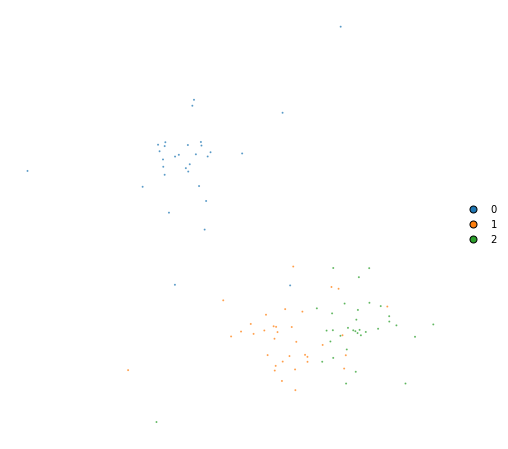

In [25]:
import utils

utils.plot(embedding_train_1, y_train)

In [26]:
%time embedding_train_2 = embedding_train_1.optimize(n_iter=750, momentum=0.8)

Iteration   50, KL divergence  0.4077, 50 iterations in 3.0244 sec
Iteration  100, KL divergence  0.3013, 50 iterations in 3.0851 sec
Iteration  150, KL divergence  0.2891, 50 iterations in 3.6652 sec
Iteration  200, KL divergence  0.2892, 50 iterations in 4.2379 sec
Iteration  250, KL divergence  0.2878, 50 iterations in 2.6357 sec
Iteration  300, KL divergence  0.2786, 50 iterations in 3.7697 sec
Iteration  350, KL divergence  0.3010, 50 iterations in 3.9746 sec
Iteration  400, KL divergence  0.2693, 50 iterations in 4.3909 sec
Iteration  450, KL divergence  0.2878, 50 iterations in 5.5242 sec
Iteration  500, KL divergence  0.2903, 50 iterations in 6.3756 sec
Iteration  550, KL divergence  0.3016, 50 iterations in 7.6603 sec
Iteration  600, KL divergence  0.2985, 50 iterations in 10.8761 sec
Iteration  650, KL divergence  0.3104, 50 iterations in 7.4258 sec
Iteration  700, KL divergence  0.3018, 50 iterations in 6.4892 sec
Iteration  750, KL divergence  0.3012, 50 iterations in 5.315

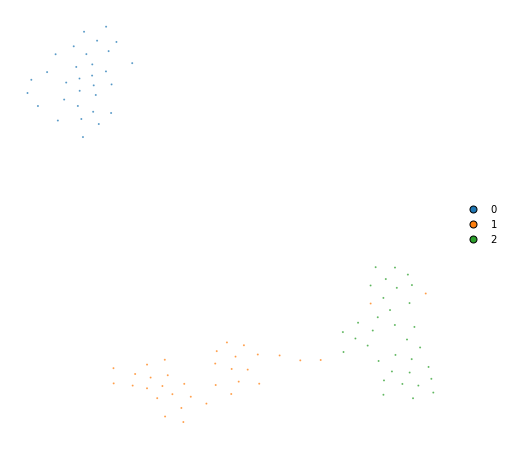

In [27]:
utils.plot(embedding_train_2, y_train)

## Transform

In [ ]:
%%time
embedding_test = embedding_train_2.prepare_partial(
    x_test,
    initialization="median",
    k=25,
    perplexity=5,
)

In [ ]:
utils.plot(embedding_test, y_test)

In [ ]:
%%time
embedding_test_1 = embedding_test.optimize(
    n_iter=100,
    learning_rate=1,
    exaggeration=2,
    momentum=0,
)

In [ ]:
utils.plot(embedding_test_1, y_test)

## Together

We superimpose the transformed points onto the original embedding with larger opacity.

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
utils.plot(embedding_train_2, y_train, alpha=0.25, ax=ax)
utils.plot(embedding_test_1, y_test, alpha=0.75, ax=ax)

---

### Test inheritance:

In [ ]:
class base():
    def __init__(self):
        init = "Init Base"
        print(init)
    def bark(self):
        print("woof")
        
#currently (full override):
class over(base):
    def __init__(self):
        init = "Init Previous"
        print(init)
    def berk(self):
        print("dog.bark(self)")

billo = dug()  

#with super:
class sup(base):
    def __init__(self):
        super(deg, self).__init__()
        init = "Init Super"
        print(init)
    def berk(self):
        print("dog.bark(self)")

bello = deg()

### Test numpy array:

In [ ]:
import numpy as np

print("x.shape: {}".format(x.shape))
arr = np.empty(x.shape)
#print("arr: {}".format(arr))
entry = [0,1,2,3]
arr[0] = entry
print("arr + entry {}".format(arr[0]))

In [ ]:
import numpy as np

#index = neighbors, distances
data = [[[0,1,2,3],[0,20,30,40]],[[1,1,2,3],[10,20,30,40]],[[2,1,2,3],[20,20,30,40]],
[[3,1,2,3],[30,20,30,40]],[[4,1,2,3],[40,20,30,40]]]

neighbors = np.empty((5,4))
distances = np.empty((5,4))

for i in range(len(data)):
    #neighbors_single, distances_single = np.asarray(data[i])
    neighbors[i], distances[i] = np.asarray(data[i])
#    neighbors[i] = neighbors_single
#    distances[i] = distances_single
      
print(neighbors)
print(distances)






#indexarr = np.asarray(indexlist)
#np.append(indexarr[1],np.asarray(indexlist1)[1], axis=0)
#neig, dist = indexarr[1]
#np.append(indexarr[0],np.asarray(indexlist1)[1], axis=0)

#print(indexarr)


#neigh = np.empty((4,4))
#dist = np.empty

#empty[0] = indexarr[0]
#print("")
#print(empty)




#### Test difference range, enumerate for data

In [ ]:
#X = [[1,2,3],[4,5,6]]
     
#for i,x in enumerate(X):
#    print(i,x)
    
#n_items, vector_length = x.shape
#for i, j in range(n_items):
#    print(j[i], i)
#print("")
#for i,j in enumerate(x):
#    print(i,j)